In [5]:
# imports needed
import pickle
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

In [6]:
def process_subject(subject_path, win=7000, stride=3500):
    with open(os.path.join(subject_path, f"{os.path.basename(subject_path)}.pkl"), "rb") as f:
        data = pickle.load(f, encoding='latin1')

    chest = data["signal"]["chest"]
    labels = data["label"]

    if isinstance(chest, dict):
        ecg = chest["ECG"]
        acc = chest["ACC"]
    else:
        ecg = chest[:, 0]
        acc = chest[:, 5:8]

    ecg_out, acc_out, y_out = [], [], []
    for i in range(0, len(labels) - win, stride):
        l = labels[i:i+win]
        if np.all(l == 2):
            label = 1
        elif np.all(np.isin(l, [1, 3])):
            label = 0
        else:
            continue
        ecg_out.append(ecg[i:i+win])
        acc_out.append(acc[i:i+win])
        y_out.append(label)

    return np.array(ecg_out), np.array(acc_out), np.array(y_out)


In [7]:
# Excluding excluding S1 and S12 as mentioned in the dataset README
subject_ids = [f"S{i}" for i in range(2, 18) if i not in [12]]
base_path = "./"

# Load all subjects
X_ecg_all, X_acc_all, y_all = [], [], []

for sid in subject_ids:
    folder = os.path.join(base_path, sid)
    if not os.path.exists(os.path.join(folder, f"{sid}.pkl")):
        print(f"Skipping {sid}, file not found.")
        continue
    print(f"Processing {sid}")
    X_ecg, X_acc, y = process_subject(folder)
    X_ecg_all.append(X_ecg)
    X_acc_all.append(X_acc)
    y_all.append(y)

# combine all of the data
X_ecg_all = np.concatenate(X_ecg_all)
X_acc_all = np.concatenate(X_acc_all)
y_all = np.concatenate(y_all)

# Normalize
X_ecg_all = (X_ecg_all - np.mean(X_ecg_all)) / np.std(X_ecg_all)
X_acc_all = (X_acc_all - np.mean(X_acc_all)) / np.std(X_acc_all)

# Train/test split
X_ecg_train, X_ecg_test, X_acc_train, X_acc_test, y_train, y_test = train_test_split(
    X_ecg_all, X_acc_all, y_all, test_size=0.2, random_state=42
)

#model function
def build_model(ecg_shape, acc_shape):
    ecg_in = tf.keras.Input(shape=ecg_shape)
    x1 = tf.keras.layers.Reshape((ecg_shape[0], 1))(ecg_in)
    x1 = tf.keras.layers.Conv1D(16, 5, activation='relu')(x1)
    x1 = tf.keras.layers.MaxPooling1D(2)(x1)
    x1 = tf.keras.layers.LSTM(32)(x1)

    acc_in = tf.keras.Input(shape=acc_shape)
    x2 = tf.keras.layers.Conv1D(16, 5, activation='relu')(acc_in)
    x2 = tf.keras.layers.MaxPooling1D(2)(x2)
    x2 = tf.keras.layers.LSTM(32)(x2)

    x = tf.keras.layers.concatenate([x1, x2])
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[ecg_in, acc_in], outputs=out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

# Training the mdoel
model = build_model(X_ecg_train.shape[1:], X_acc_train.shape[1:])
history = model.fit([X_ecg_train, X_acc_train], y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluating model
y_pred = model.predict([X_ecg_test, X_acc_test])

# finding the best threshold
# for i in range(1,11):
#     y_pred_bin = (y_pred > i/10).astype(int)
#     print(classification_report(y_test, y_pred_bin))
#     print("AUC-ROC:", roc_auc_score(y_test, y_pred))
#     plot_training(history)
#     plot_confusion(y_test, y_pred_bin)
#     plot_roc(y_test, y_pred)

y_pred_bin = (y_pred > 0.3).astype(int)

print(classification_report(y_test, y_pred_bin))
print("AUC-ROC:", roc_auc_score(y_test, y_pred))


Processing S2
Processing S3


In [3]:
def plot_training(history):
    metrics = history.history
    auc_key = 'auc' if 'auc' in metrics else 'AUC' if 'AUC' in metrics else None

    plt.figure(figsize=(10, 4))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(metrics['accuracy'], label='Train Accuracy', linewidth=2)
    plt.plot(metrics['val_accuracy'], label='Val Accuracy', linestyle='--', linewidth=2)
    plt.title("Model Accuracy", fontsize=14)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # AUC
    plt.subplot(1, 2, 2)
    if auc_key:
        plt.plot(metrics[auc_key], label='Train AUC', linewidth=2)
        plt.plot(metrics[f'val_{auc_key}'], label='Val AUC', linestyle='--', linewidth=2)
        plt.title("Model AUC", fontsize=14)
        plt.xlabel("Epoch")
        plt.ylabel("AUC")
        plt.legend()
    else:
        plt.title("AUC not available in history")

    plt.tight_layout()
    plt.show()


In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion(y_true, y_pred_binary):
    cm = confusion_matrix(y_true, y_pred_binary)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Stress", "Stress"])
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(cmap='Purples', ax=ax, colorbar=False)
    plt.title("Confusion Matrix", fontsize=14)
    plt.grid(False)
    plt.savefig("confusion_matrix_black.png", dpi=300, facecolor='black')
    plt.show()


In [2]:
from sklearn.metrics import roc_curve, auc

def plot_roc(y_true, y_probs):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='deepskyblue', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve", fontsize=14)
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.savefig("roc_curve_black.png", dpi=300, facecolor='black')
    plt.show()


In [21]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file="model_architecture.png", show_shapes=True, show_layer_names=True, dpi=100)


You must install pydot (`pip install pydot`) for `plot_model` to work.


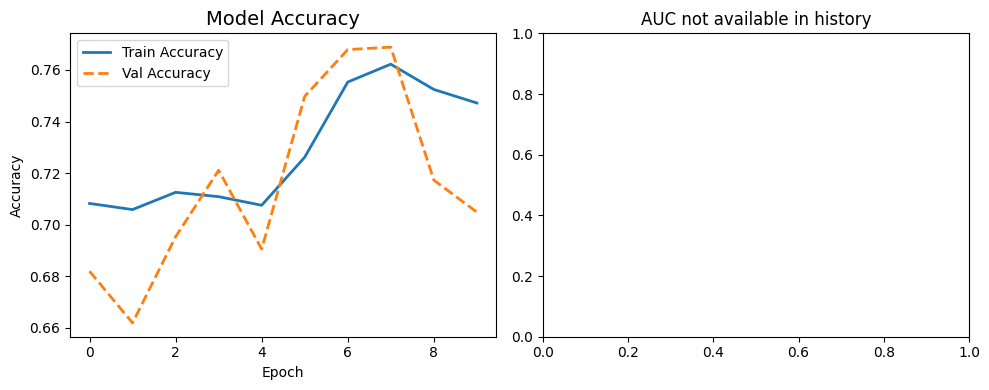

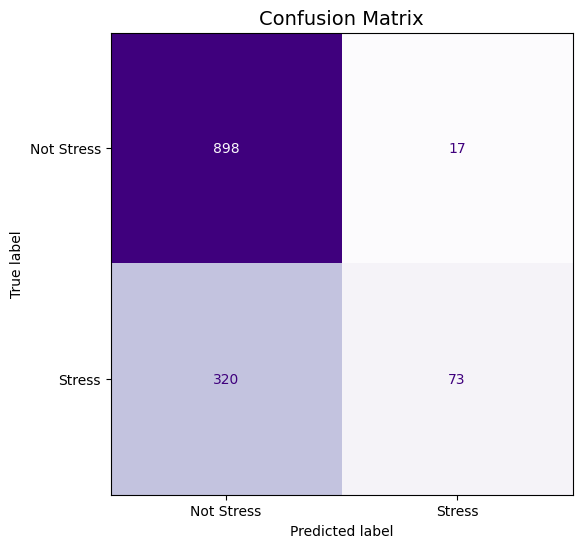

/var/folders/cw/_f9cn_6x41q2s5rsch700m200000gn/T/ipykernel_33356/1731440461.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray')


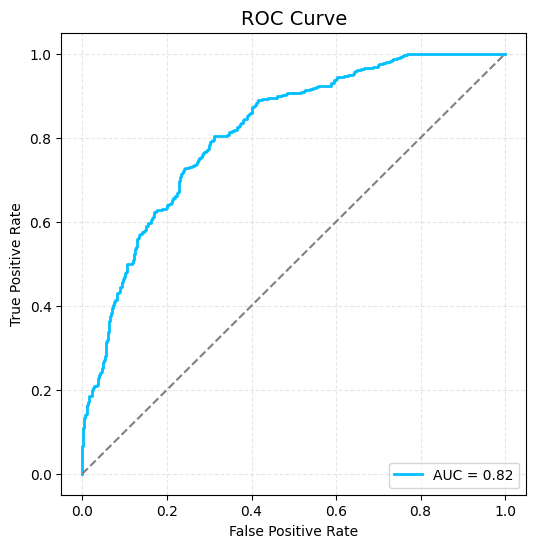

In [25]:
plot_training(history)
plot_confusion(y_test, y_pred_bin)
plot_roc(y_test, y_pred)